In [21]:
"""

This file contains all curve fitting used for the emission lines:
least squares circle fit (LSF), LMA circle fit, parabolic arc fit, and a LSF line fit.

"""
import scipy.stats as stats
import scipy.optimize as optimize
import scipy as sc
import numpy as np
import math

def LSF(x,y):
# coordinates of the barycenter
    x_m = np.mean(x)
    y_m = np.mean(y)

    def di(a, b):
        return math.sqrt((x-a)**2 + (y-b)**2)

    def f(c):
        Ri = di(*c)
        return Ri - Ri.mean()

    center_estimate = x_m, y_m
    center, ier = optimize.leastsq(f, center_estimate)

    a, b = center
    Ri     = di(*center)
    R      = Ri.mean()
    residu = sum((Ri - R)**2)

    return a,b,R,residu

def LMA(x,y):
    """Implements LMA algorithm from Chernov 2008 "Least squares fitting of circles and lines" 
    """
    def ui(x,y,theta):
        u = x * math.cos(theta) + y * math.sin(theta)
        return u

    def zi(x,y):
        z = x**2 + y**2
        return z

    def EE(A,D):
        E = math.sqrt(1+4*A*D)
        return E

    def di(A,D,theta):
        u = ui(x,y,theta)
        z = zi(x,y)
        E = EE(A,D)
        p = A*z + E*u + D
        ap = 1+4*A*p
        di = 2 * (p / (1+np.sqrt(ap)))
        return di

    def abr_to_adt(abr):
        a = abr[0]
        b = abr[1]
        r = abr[2]
        A = 1 / (2*r)
        B = - 2*A*a
        C = - 2*A*b
        D = (B*B + C*C - 1) / (4*A)

        theta = np.arccos(-a / np.sqrt(a*a + b*b))
        return A,D,theta

    def f(abr):
        A,D,theta = abr_to_adt(abr)
        dist = di(A,D,theta)
        return dist*dist

    def jac(abr):
        A,D,theta = abr_to_adt(abr)
        u = ui(x,y,theta)
        z = zi(x,y)
        E = EE(A,D)
        p = A*z + E*u + D
        Qi = np.sqrt(1+4*A*p)
        dist = di(A,D,theta)
        Ri = (2*(1-A*dist/Qi))/(Qi+1)
        dA = (z + (2*D*u)/E) * Ri - (dist*dist) / Qi
        dD = (2*A*u / E + 1) * Ri
        dT = (-x * math.sin(theta) + y * math.cos(theta)) * E * Ri
        return np.array(list(zip(dA,dD,dT)))
    
    # Use LSF to get initial guess for circle parameters.
    a,b,r = LSF(x,y)

    # Minimize f with initial guess a,b,r. Uses Levenberg-Maquardt (method='lm')
    res = optimize.least_squares(f, (a,b,r), jac=jac, method='lm')
    return res.x[0], res.x[1], res.x[2], float('Nan')

def parabolicFit(x,y, p0=None):
    """ Fit a parabola to set of x,y points.
    """
    def parabola(x,a,b,c):
        return a*x**2 + b*x + c
    
    def jac(x,a,b,c):
        da = x**2
        db = x
        dc = np.ones_like(x)
        return np.array(list(zip(da,db,dc)))

    # Give coordinates in inverted order to get sideways parabola x = ay^2 + by + c
    p, pcov = sc.optimize.curve_fit(parabola, y, x, p0=p0, jac=jac)
    a = p[0]
    b = p[1]
    c = p[2]
    # The vertex
    # V = ((4*a*c - b**2) / (4*a), -b / (2*a))
    # Focus
    # F = ((4*a*c - b**2 + 1) / (4*a), -b / (2*a))
    return a,b,c

def line_fit(x,y):
    """Fit a least squares line to data.
    """
    A,B,_,_,_ = stats.linregress(y, x)
    return 1/A,-B/A

if __name__ == '__main__':
    print("curve_fit.py called as script. No need to run anything.")

curve_fit.py called as script. No need to run anything.


In [5]:
import math
import numpy as np

class SpectralLine:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        # Correct location of the SL assumed mean of points. Can also use 
        # circ_cntr_x - circ_r. Using mean prevents the lines moving too far from 
        # their original positions.
        self.location = np.mean(x)
        # LSF can be changed to LMA if desired. 
        # But not for parabolic as they have different return values!
        self.circ_cntr_x, self.circ_cntr_y, self.circ_r,_ = LSF(x,y)
        self.line_a, self.line_b = line_fit(x,y)
        self.tilt_angle_degree_abs = 90 - abs(math.atan(self.line_a) * 57.2957795)
        a_tan = math.degrees(-math.atan(self.line_a))
        self.tilt = math.copysign(90 - abs(a_tan), a_tan)

        # Parabolic fit to estimate curvature
        p0 = [1 / (2 * self.circ_r), 0.0, self.location]
        a, _, _ = parabolicFit(x,y,p0)
        self.curvature = 2 * a

In [7]:
import numpy as np
from scipy.interpolate import interp1d
import scipy.signal as signal
import xarray as xr
import math

#from core.spectral_line import SpectralLine

# Define properties inline
class Properties:
    dim_x = "x"      # x-axis name
    dim_y = "y"      # y-axis name
    dim_scan = "scan"  # scan dimension name for hyperspectral data cube

P = Properties()


def construct_bandpass_filter(peak_light_frame, location_estimates, filter_window_width):
    # Initialize return values (low and high value vectors are both the width of the frame).
    low = np.zeros(peak_light_frame[P.dim_x].size)
    high = np.zeros(peak_light_frame[P.dim_x].size)
    # Half width for calculations.
    w = int(filter_window_width / 2)
    # x-coordinate of previous filter window end point.
    last_stop = 0

    for _,le in enumerate(location_estimates):
        try:
            max_val = peak_light_frame.isel(x=slice(le-w,le+w)).max(dim=[P.dim_x,P.dim_x])
        except ValueError as ve:
            # Use maximum of the whole frame as a backup.
            max_val = np.max(peak_light_frame.values)
            
        start = le-w
        # Ensure windows are separate even if given locations are closer than w. 
        if start <= last_stop:
            start = last_stop + 1
        # May result in narrower filter but does not push following filters away from their intended position.
        stop  = le + w
        # Check array bounds
        if stop >= len(high):
            stop = len(high)-1
        last_stop = stop

        # Fill the area around spectral line locations with non-zero values.
        idx = np.arange(start=start,stop=stop)
        for _,j in enumerate(idx):
            high[j] = max_val * 1.2

    return low,high

def construct_spectral_lines(peak_light_frame, location_estimates, bandpass, peak_width=3):
    rowList = []
    accepted_row_index = []
    spectral_line_list = []

    # Iterate frame rows to find peaks from given locations on each row.
    for i in range(peak_light_frame.y.size):

        row = peak_light_frame.isel(y=i).values
        rowPeaks, _ = signal.find_peaks(row, height=bandpass, width=peak_width)

        if len(rowPeaks) == len(location_estimates):
            accepted_row_index.append(i)
            rowList.append(rowPeaks)

    rowList = np.asarray(rowList)
    accepted_row_index = np.asarray(accepted_row_index)

    # Once each row that succesfully found same amount of peaks that there are location_estimates,
    # we can form the actual spectral line objects.
    for i in range(len(rowList[0])):
            x = rowList[:,i]
            y = accepted_row_index
            line = SpectralLine(x,y) 
            # Discard lines with too small radius. They are false alarms.
            if line.circ_r > peak_light_frame.x.size:
                spectral_line_list.append(line)

    if len(spectral_line_list) < 1:
        raise RuntimeWarning(f"All spectral lines were ill formed.")

    return spectral_line_list


def construct_shift_matrix(spectral_lines, w, h):
    
    shift_matrix = xr.DataArray(np.zeros((h,w)), dims=('y','x'))

    # Switch to single circle method if only one spectral line was recieved.
    if len(spectral_lines) == 1:
        shift_matrix = _single_circle_shift(shift_matrix, spectral_lines, w)
    else:
        shift_matrix = _multi_circle_shift(shift_matrix, spectral_lines, w)

    return shift_matrix

def _single_circle_shift(shift_matrix, spectral_lines, w):
    """ Create shifts using a single spectral line. """

    sl = spectral_lines[0]
    for x in range(shift_matrix.y.size):
        xx = x - sl.circ_cntr_y
        theta = math.asin(xx / sl.circ_r)
        py = (1 - math.cos(theta)) * math.copysign(sl.circ_r, sl.circ_cntr_x)
        for l in range(w):
            shift_matrix.values[x, l] = py

    return shift_matrix

def _multi_circle_shift(shift_matrix, spectral_lines, w):
    """ Create shift matrix by interpolating several spectral lines. """
        
    # x coordinates of spectral lines. First element set to 0, last to the width of the frame.
    x_coords = []

    for i,sl in enumerate(spectral_lines):
        pl = sl.location
        x_coords.append(pl)

        if i == 0 or i == (len(spectral_lines)-1):
            # Add an element to beginning and end of list
            x_coords.append(pl)

    # Overwrite the extra elements
    x_coords[0] = 0
    x_coords[len(x_coords)-1] = w

    for row_idx in range(shift_matrix.y.size):
        shifts = []
        for i,sl in enumerate(spectral_lines):
            h = row_idx - sl.circ_cntr_y
            theta = math.asin(h / sl.circ_r)
            d = (1 - math.cos(theta)) * math.copysign(sl.circ_r, sl.circ_cntr_x)
            shifts.append(d)
            if i == 0 or i == (len(spectral_lines)-1):
            # Set first element same as the second, and last same as second to last.
                shifts.append(d)

        f = interp1d(x_coords, shifts)

        row = np.arange(w)
        shift_linear_fit = f(row)

        for l,d in enumerate(shift_linear_fit):
            shift_matrix.values[row_idx,l] = d

    return shift_matrix

def apply_shift_matrix(target, shift_matrix, method=0, target_is_cube=True):

    if method == 0:
        if target_is_cube:
            desmiled_target = _lut_shift_cube(target, shift_matrix)
        else:
            desmiled_target = _lut_shift_frame(target, shift_matrix)
    elif method == 1:
        if target_is_cube:
            desmiled_target = _intr_shift_cube(target, shift_matrix)
        else:
            desmiled_target = _intr_shift_frame(target, shift_matrix)
    else:
        raise ValueError(f"Method must be either 0 or 1. Was {method}.")

    return desmiled_target

def _lut_shift_cube(cube, shift_matrix):
    """ Apply lookup table shift for a hyperspectral image cube. """
    ix,iy  = _shift_matrix_to_index_matrix(shift_matrix)
    vals = np.zeros_like(cube.reflectance)
    for i,frame in enumerate(cube.reflectance.values):        
        vals[i,:,:] = frame[iy, ix]
    cube.reflectance.values = vals
    return cube

def _lut_shift_frame(frame, shift_matrix):
    """ Apply lookup table shift for a single frame. """
    ix, iy = _shift_matrix_to_index_matrix(shift_matrix)
    frame.values[:,:] = frame.values[iy, ix]
    return frame

def _shift_matrix_to_index_matrix(shift_matrix):
    index_x = np.zeros_like(shift_matrix.values,dtype=int)
    index_y = np.zeros_like(shift_matrix.values,dtype=int)

    for x in range(shift_matrix.x.size):
        for y in range(shift_matrix.y.size):
            index_x[y,x] = int(round(x + shift_matrix.values[y,x]))
            index_y[y,x] = y

    # Clamp so that indices won't go out of bounds.
    index_x = np.clip(index_x, 0, x-1)
    return index_x,index_y

def _intr_shift_frame(frame, shift_matrix):
    """ Desmile frame using row-wise interpolation of pixel intensities. """
    ds = xr.Dataset(
        data_vars={
            'frame'      :   frame,
            'x_shift'    :   shift_matrix,
            },
    )

    ds['desmiled_x'] = ds.x - ds.x_shift
    min_x = frame.x.min().item()
    max_x = frame.x.max().item()
    ds.coords['new_x'] = np.linspace(min_x, max_x, frame.x.size)
    ds = ds.groupby('y').apply(_desmile_row)

    ds = ds.drop('x_shift')
    ds = ds.drop('x')
    renames = {'new_x':'x'}
    ds = ds.rename(renames)
    
    return ds.frame

def _intr_shift_cube(cube, shift_matrix):
    """ Desmile cube using row-wise interpolation of pixel intensities.  """

    ds = xr.Dataset(
        data_vars={
            'reflectance'      :   cube.reflectance,
            'x_shift'    :   shift_matrix,
            },
    )
    ds['desmiled_x'] =  ds[P.dim_x] - ds.x_shift

    min_x = cube.reflectance.x.min().item()
    max_x = cube.reflectance.x.max().item()
    ds.coords['new_x'] = np.linspace(min_x, max_x, cube.reflectance.x.size)

    gouped = ds.groupby(P.dim_y)
    ds = gouped.apply(_desmile_row).astype(np.float32)
    ds = ds.drop('x_shift')
    ds = ds.drop(P.dim_x)
    renames = {'new_x':'x'}
    ds = ds.rename(renames)
    # Transpose back into original shape.
    # I was unable to find out why apply() switches the 
    # dimensions to (y, index, x)
    ds = ds.transpose(P.dim_scan, P.dim_y, P.dim_x)
    isNan = np.isnan(ds.reflectance.values).any()
    if isNan:
        print(f"Interpolatively shifted cube contains NaNs.")
    isInf = np.isinf(ds.reflectance.values).any()
    if isInf:
        print(f"Interpolatively shifted cube contains Infs.")
    # Fix NaNs before comparing for negatives.
    if isNan or isInf:
        ds.reflectance.values = np.nan_to_num(ds.reflectance.values).astype(np.float32)
    isNeg = (ds.reflectance.values < 0.0).any()
    if isNeg:
        print(f"Interpolatively shifted cube contains negative values.")
        ds.reflectance.values = np.clip(ds.reflectance.values, a_min=0.0).astype(np.float32)
    if isNan or isInf or isNeg:
        isNan = np.isnan(ds.reflectance.values).any()
        print(f"After fixing: Interpolatively shifted cube contains NaNs ({isNan}).")
        isInf = np.isinf(ds.reflectance.values).any()
        print(f"After fixing: Interpolatively shifted cube contains Infs ({isInf}).")
        isNeg = np.any(ds.reflectance.values < 0.0)    
        print(f"After fixing: Interpolatively shifted cube contains negative values ({isNeg}).")
    return ds

def _desmile_row(row):
    """ Interpolate a single row. """

    row['x'] = row.desmiled_x
    new_x = row.new_x
    row = row.drop(['desmiled_x','new_x'])
    row = row.interp(x=new_x, method='linear')
    return row

# My Code

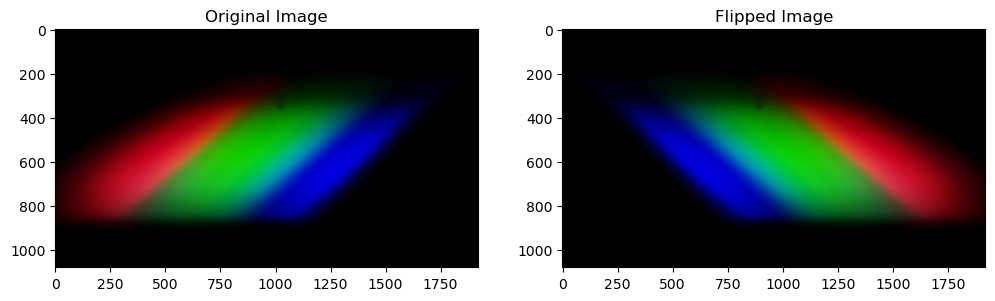

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image_path = "/Users/muntasirmahmud/Library/CloudStorage/OneDrive-UMBC/4. SciGlob/code/image/captured_image_20240816_094441.png"
image = Image.open(image_path)

# Flip the image horizontally
flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)

# Save the flipped image (optional)
#flipped_image.save("flipped_image.png")

# Display the original and flipped images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("on")

plt.subplot(1, 2, 2)
plt.title("Flipped Image")
plt.imshow(flipped_image)
plt.axis("on")

plt.show()


In [63]:
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import least_squares
from scipy.ndimage import map_coordinates

def locate_emission_lines(image, row_range, prominence=1):
    """
    Locate emission lines in the image for given row range.
    Args:
        image (numpy array): The hyperspectral image (2D array).
        row_range (tuple): The range of rows to process (start_row, end_row).
        prominence (float): Minimum prominence for peak detection.
    Returns:
        emission_points (list): List of emission line coordinates [(x1, y1), (x2, y2), ...].
    """
    emission_points = []
    for y in range(row_range[0], row_range[1]):
        row_data = image[y, :]
        peaks, _ = find_peaks(row_data, prominence=prominence)
        emission_points.extend([(x, y) for x in peaks])
    return emission_points

def fit_circular_arc(points):
    """
    Fit a circular arc to a set of points using least-squares fitting.
    Args:
        points (list): List of (x, y) points.
    Returns:
        (center_x, center_y, radius): Parameters of the fitted circle.
    """
    def residuals(params, x, y):
        cx, cy, r = params
        return np.sqrt((x - cx)**2 + (y - cy)**2) - r

    x, y = zip(*points)
    x, y = np.array(x), np.array(y)

    # Initial guess for the center and radius
    center_guess = (np.mean(x), np.mean(y))
    radius_guess = np.mean(np.sqrt((x - center_guess[0])**2 + (y - center_guess[1])**2))
    params_guess = (*center_guess, radius_guess)

    result = least_squares(residuals, params_guess, args=(x, y))
    return result.x

def generate_arc(center_x, center_y, radius, y_points):
    """
    Generate x-coordinates of a circular arc given center, radius, and y-points.
    Args:
        center_x, center_y (float): Center of the arc.
        radius (float): Radius of the arc.
        y_points (array): Y-coordinates of the arc.
    Returns:
        x_points (array): X-coordinates corresponding to the y_points.
    """
    return center_x + np.sqrt(radius**2 - (y_points - center_y)**2)


def construct_shift_matrix(image, emission_line_params):
    shift_matrix = np.zeros_like(image, dtype=float)
    for center_x, center_y, radius in emission_line_params:
        for y in range(image.shape[0]):
            dy = y - center_y
            # Calculate relative shifts instead of absolute
            if radius**2 - dy**2 > 0:
                dx = radius - np.sqrt(radius**2 - dy**2)
            else:
                dx = 0
            shift_matrix[y, :] += dx
    return shift_matrix

def construct_shift_matrix_paper(image, center_y, radius):
    """
    Construct a shift matrix using the formula from the paper.
    Args:
        image (numpy array): The hyperspectral image (2D array).
        center_y (float): Y-coordinate of the center of the arc.
        radius (float): Radius of the circular arc.
    Returns:
        shift_matrix (numpy array): The calculated shift matrix for the image.
    """
    shift_matrix = np.zeros_like(image, dtype=float)
    for y in range(image.shape[0]):
        # Calculate the shift (d) using the paper's formula
        dy = y - center_y
        if abs(dy) <= radius:  # Ensure valid arcsin input
            shift = radius * (1 - np.cos(np.arcsin(dy / radius)))
        else:
            shift = 0  # Outside the arc range
        shift_matrix[y, :] = shift  # Apply uniform shift to the entire row
    return shift_matrix

def apply_shift_matrix(image, shift_matrix):
    """
    Apply the shift matrix to warp the image rows.
    Args:
        image (numpy array): The original hyperspectral image.
        shift_matrix (numpy array): The shift matrix.
    Returns:
        corrected_image (numpy array): The corrected image.
    """
    corrected_image = np.zeros_like(image)
    for y in range(image.shape[0]):
        x_indices = np.arange(image.shape[1]) - shift_matrix[y, :]
        x_indices = np.clip(x_indices, 0, image.shape[1] - 1)  # Ensure valid indices
        corrected_image[y, :] = map_coordinates(image[y, :], [x_indices], order=1, mode='nearest')
    return corrected_image

def apply_shift_matrix_to_all_bands(image, shift_matrix):
    """
    Apply the shift matrix to a 3D hyperspectral image (all bands at once).
    Args:
        image (numpy array): The hyperspectral image (3D array: rows, columns, bands).
        shift_matrix (numpy array): The calculated shift matrix for the image.
    Returns:
        corrected_image (numpy array): The corrected hyperspectral image.
    """
    corrected_image = np.zeros_like(image)
    for y in range(image.shape[0]):
        x_indices = np.arange(image.shape[1]) - shift_matrix[y, :]
        x_indices = np.clip(x_indices, 0, image.shape[1] - 1)  # Ensure valid indices
        for band in range(image.shape[2]):  # Apply the same shift to all bands
            corrected_image[y, :, band] = map_coordinates(image[y, :, band], [x_indices], order=1, mode='nearest')
    return corrected_image

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


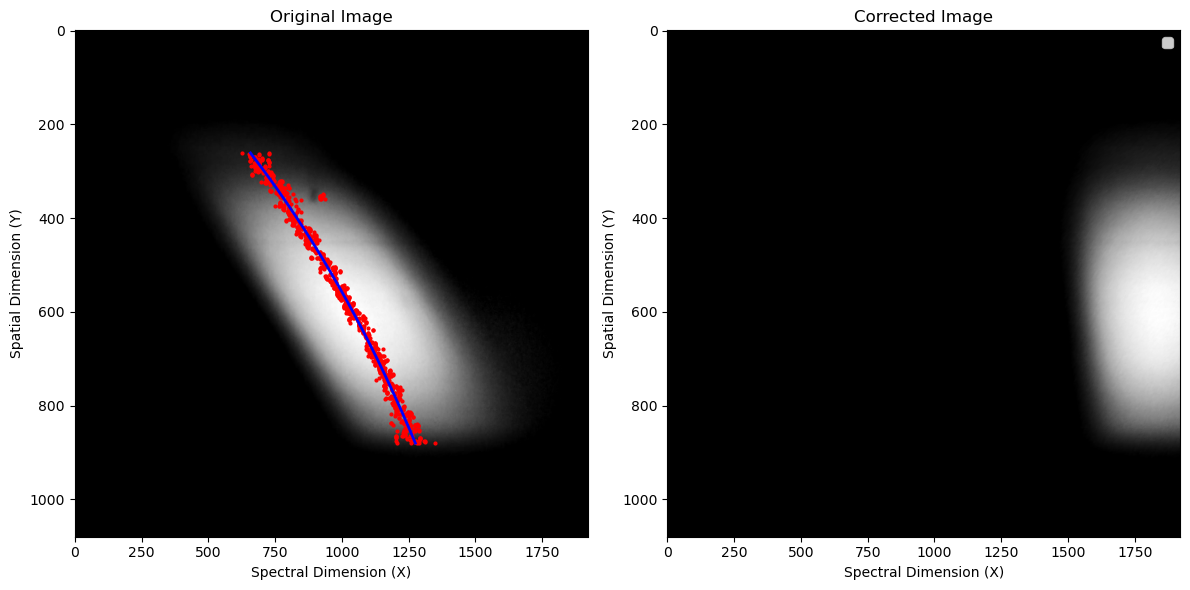

In [313]:
import matplotlib.pyplot as plt

# Load your image (hyperspectral frame as a 2D NumPy array)
image = plt.imread("flipped_image.png")[:, :, 1]  # Load as grayscale or use the correct channel

# Define the range of rows to process (e.g., the entire image or specific rows)
row_range = (0, image.shape[0])

# Locate emission lines
emission_points = np.array(locate_emission_lines(image, row_range, prominence=0.1))
x_detected, y_detected = emission_points[:, 0], emission_points[:, 1]

# Step 1: Fit circular arc to detected emission lines
center_x, center_y, radius = fit_circular_arc(emission_points)

# Generate fitted arc
y_arc = np.linspace(min(y_detected), max(y_detected), 1000)
x_arc = generate_arc(center_x, center_y, radius, y_arc)

# Step 2: Construct the shift matrix
emission_line_params = [(center_x, center_y, radius)]  # List of arc parameters for all detected lines
# shift_matrix = construct_shift_matrix(image, emission_line_params)
shift_matrix = construct_shift_matrix_paper(image, center_y, radius)

# Step 3: Apply the shift matrix to correct the image
corrected_image = apply_shift_matrix(image, shift_matrix)

# Step 4: Plot original and corrected images side by side
plt.figure(figsize=(12, 6))
# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray', aspect='auto')
# Overlay detected points
plt.plot(x_detected, y_detected, 'ro', markersize=2, label="Detected Emission Line")
# Overlay fitted arc
plt.plot(x_arc, y_arc, 'b-', linewidth=2, label="Fitted Circular Arc")
plt.title("Original Image")
plt.xlabel("Spectral Dimension (X)")
plt.ylabel("Spatial Dimension (Y)")

# Plot the corrected image
plt.subplot(1, 2, 2)
plt.imshow(corrected_image, cmap='gray', aspect='auto')
plt.title("Corrected Image")
plt.xlabel("Spectral Dimension (X)")
plt.ylabel("Spatial Dimension (Y)")
plt.tight_layout()
plt.legend()
plt.show()

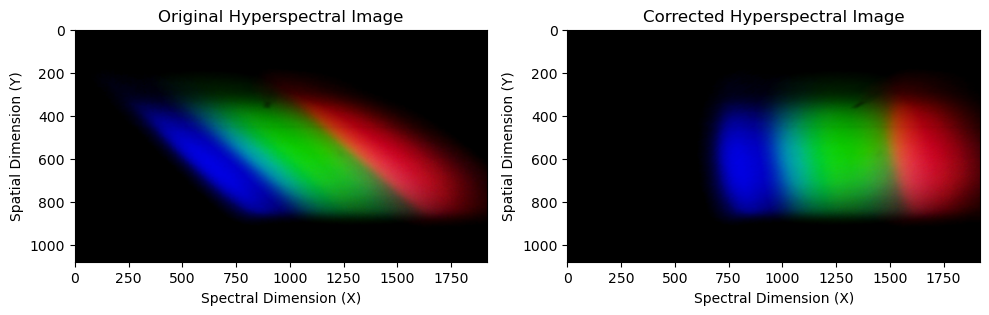

In [181]:
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
import numpy as np

# Load your hyperspectral image as a 3D NumPy array (rows, columns, spectral bands)
image = plt.imread("flipped_image.png")  # Assuming hyperspectral image is loaded as a 3D array

# Define the range of rows to process (e.g., the entire image or specific rows)
row_range = (0, image.shape[0])

# Use one channel to locate emission lines (typically a grayscale or dominant channel)
reference_channel = image[:, :, 1]  # Use one spectral band for detecting emission lines

# Locate emission lines
emission_points = np.array(locate_emission_lines(reference_channel, row_range, prominence=0.1))
x_detected, y_detected = emission_points[:, 0], emission_points[:, 1]

# Step 1: Fit circular arc to detected emission lines
center_x, center_y, radius = fit_circular_arc(emission_points)

# Generate fitted arc
y_arc = np.linspace(min(y_detected), max(y_detected), 1000)
x_arc = generate_arc(center_x, center_y, radius, y_arc)

# Step 2: Construct the shift matrix
shift_matrix = construct_shift_matrix_paper(reference_channel, center_y, radius)


# Step 3: Apply the shift matrix to all bands
def apply_shift_matrix_to_all_bands(image, shift_matrix):
    """
    Apply the shift matrix to a 3D hyperspectral image (all bands at once).
    Args:
        image (numpy array): The hyperspectral image (3D array: rows, columns, bands).
        shift_matrix (numpy array): The calculated shift matrix for the image.
    Returns:
        corrected_image (numpy array): The corrected hyperspectral image.
    """
    corrected_image = np.zeros_like(image)
    for y in range(image.shape[0]):
        x_indices = np.arange(image.shape[1]) - shift_matrix[y, :] + 600
        x_indices = np.clip(x_indices, 0, image.shape[1] - 1)  # Ensure valid indices
        for band in range(image.shape[2]):  # Apply the same shift to all bands
            corrected_image[y, :, band] = map_coordinates(image[y, :, band], [x_indices], order=1, mode='nearest')
    return corrected_image


corrected_image = apply_shift_matrix_to_all_bands(image, shift_matrix)

# Step 4: Plot the entire image (not grayscale or individual bands)
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
# Plot the original hyperspectral image
plt.imshow(image)
plt.title("Original Hyperspectral Image")
plt.xlabel("Spectral Dimension (X)")
plt.ylabel("Spatial Dimension (Y)")

plt.subplot(1, 2, 2)
plt.imshow(corrected_image)
plt.title("Corrected Hyperspectral Image")
plt.xlabel("Spectral Dimension (X)")
plt.ylabel("Spatial Dimension (Y)")
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd

# Convert the shift matrix to a DataFrame
shift_matrix_df = pd.DataFrame(shift_matrix)

# Save the DataFrame to a CSV file
shift_matrix_df.to_csv("shift_matrix.csv", index=False, header=False)

print("Shift matrix saved to shift_matrix.csv")


Shift matrix saved to shift_matrix.csv


In [183]:
def generate_arc(center_x, center_y, radius, y_points):
    return center_x + np.sqrt(radius**2 - (y_points - center_y)**2)

# Fix in apply_shift_matrix
def apply_shift_matrix(image, shift_matrix):
    corrected_image = np.zeros_like(image)
    for y in range(image.shape[0]):
        x_indices = np.arange(image.shape[1]) - shift_matrix[y, :]
        x_indices = np.clip(x_indices, 0, image.shape[1] - 1)  # Ensure valid indices
        corrected_image[y, :] = map_coordinates(image[y, :], [x_indices], order=1, mode='nearest')
    return corrected_image

# Generate the fitted arc (ensure y_points covers the correct range)
y_arc = np.linspace(min(y_detected), max(y_detected), 1000)
x_arc = generate_arc(center_x, center_y, radius, y_arc)

# Select the shift matrix method
shift_matrix = construct_shift_matrix_paper(image, center_y, radius)

# Apply the shift matrix
corrected_image = apply_shift_matrix(image, shift_matrix)

# Plot original and corrected images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray', aspect='auto')
plt.plot(x_detected, y_detected, 'ro', markersize=2, label="Detected Emission Line")
plt.plot(x_arc, y_arc, 'b-', linewidth=2, label="Fitted Circular Arc")
plt.title("Original Image")
plt.xlabel("Spectral Dimension (X)")
plt.ylabel("Spatial Dimension (Y)")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(corrected_image, cmap='gray', aspect='auto')
plt.title("Corrected Image")
plt.xlabel("Spectral Dimension (X)")
plt.ylabel("Spatial Dimension (Y)")
plt.tight_layout()
plt.show()


ValueError: operands could not be broadcast together with shapes (1920,) (1920,3) 

In [11]:
print(f"Shift Matrix Range: Min = {shift_matrix.min()}, Max = {shift_matrix.max()}")
print(f"Fitted Arc Parameters: Center (x, y) = ({center_x}, {center_y}), Radius = {radius}")

Shift Matrix Range: Min = 426.8660529200795, Max = 1605.900992754329
Fitted Arc Parameters: Center (x, y) = (-1059.1893272767888, 2591.9770780981466), Radius = 2894.7186700375382


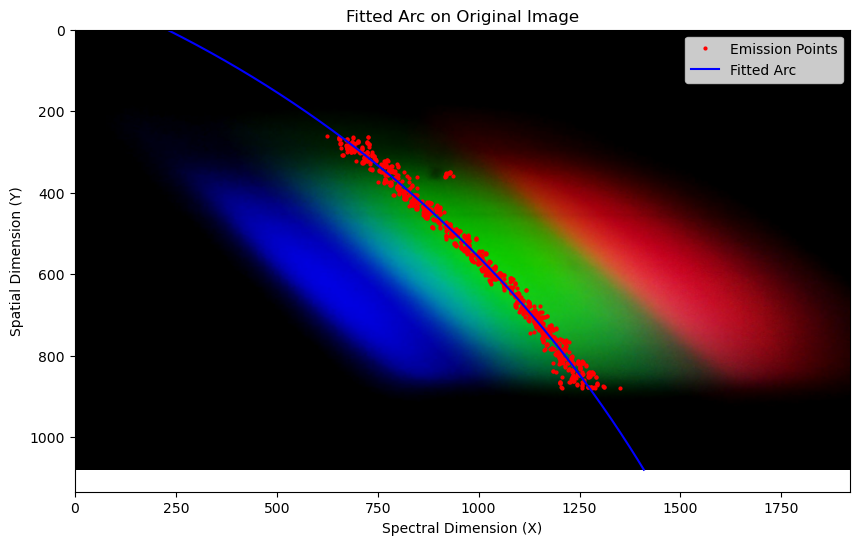

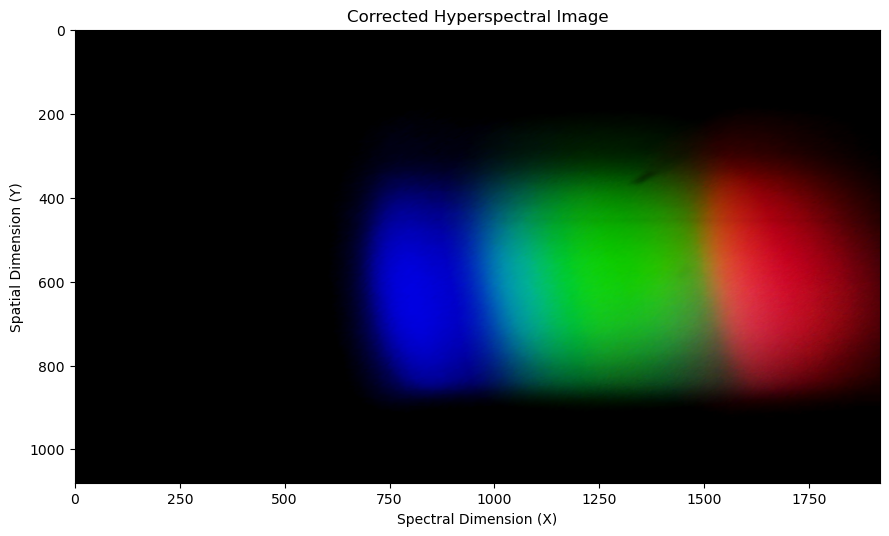

In [123]:
# Overlay the fitted arc on the emission points
y_arc = np.linspace(min(row_range), max(row_range), 1000)
x_arc = center_x + np.sqrt(radius**2 - (y_arc - center_y)**2)

plt.figure(figsize=(10, 6))
plt.imshow(image, cmap='gray', aspect='auto')
plt.title("Fitted Arc on Original Image")
plt.xlabel("Spectral Dimension (X)")
plt.ylabel("Spatial Dimension (Y)")
plt.plot(*zip(*emission_points), 'ro', markersize=2, label="Emission Points")
plt.plot(x_arc, y_arc, 'b-', label="Fitted Arc")
plt.legend()
plt.show()

plt.figure(figsize=(9, 6))
plt.imshow(corrected_image)
plt.title("Corrected Hyperspectral Image")
plt.xlabel("Spectral Dimension (X)")
plt.ylabel("Spatial Dimension (Y)")
plt.tight_layout()
plt.show()

In [7]:
import numpy as np

np.set_printoptions(threshold = np.inf)

reference_channel = image[:, :, 2]
print(max(reference_channel[:,1500]))

0.28627452


# Spectral Calibration

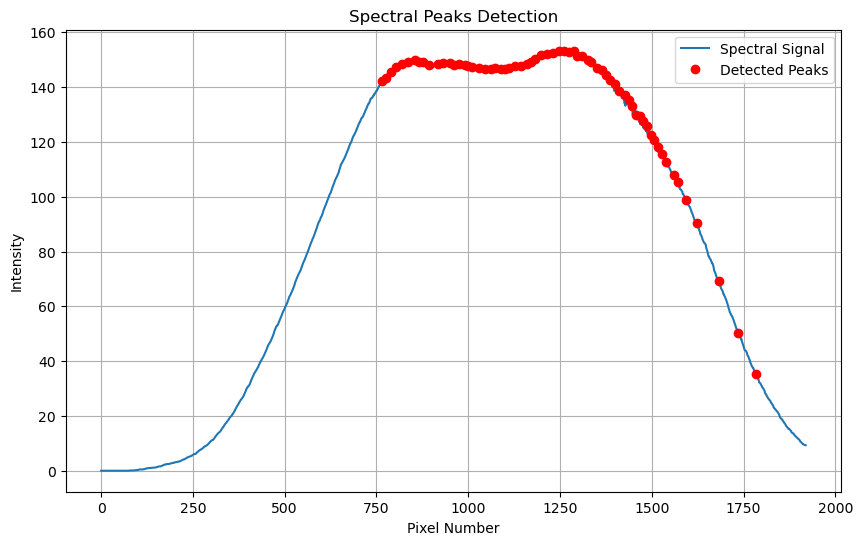

Detected Peaks (Pixel Numbers): [ 766  776  790  804  820  836  854  866  878  894  917  932  949  962
  974  990 1000 1011 1030 1046 1061 1072 1090 1100 1112 1128 1143 1159
 1171 1181 1199 1215 1231 1247 1261 1274 1287 1297 1311 1325 1335 1351
 1363 1375 1385 1399 1410 1427 1437 1447 1457 1467 1477 1487 1497 1507
 1517 1527 1538 1559 1570 1593 1623 1682 1736 1784]
Dummy Wavelengths (nm): [300.         306.15384615 312.30769231 318.46153846 324.61538462
 330.76923077 336.92307692 343.07692308 349.23076923 355.38461538
 361.53846154 367.69230769 373.84615385 380.         386.15384615
 392.30769231 398.46153846 404.61538462 410.76923077 416.92307692
 423.07692308 429.23076923 435.38461538 441.53846154 447.69230769
 453.84615385 460.         466.15384615 472.30769231 478.46153846
 484.61538462 490.76923077 496.92307692 503.07692308 509.23076923
 515.38461538 521.53846154 527.69230769 533.84615385 540.
 546.15384615 552.30769231 558.46153846 564.61538462 570.76923077
 576.92307692 583.0769

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load the spectral image
image = plt.imread("flipped_image.png")

# Step 1: Convert the image to grayscale (if needed)
if len(image.shape) == 3:  # Check if it's an RGB image
    image_gray = np.mean(image, axis=2)  # Average RGB channels to convert to grayscale
else:
    image_gray = image  # Already grayscale

# Step 2: Collapse the image across rows to get a 1D spectral signal
spectral_signal = np.sum(image_gray, axis=0)  # Summing along the rows

# Step 3: Find spectral peaks
peaks, _ = find_peaks(spectral_signal, height=np.max(spectral_signal)*0.2, distance=10)
# Adjust 'height' and 'distance' for better detection based on your data

# Step 4: Assign dummy wavelengths for now
total_pixels = 1920
wavelength_range = (300, 700)  # Wavelength range in nm
dummy_wavelengths = np.linspace(wavelength_range[0], wavelength_range[1], len(peaks))

# Step 5: Plot the spectral signal with detected peaks
plt.figure(figsize=(10, 6))
plt.plot(spectral_signal, label="Spectral Signal")
plt.plot(peaks, spectral_signal[peaks], "ro", label="Detected Peaks")
plt.xlabel("Pixel Number")
plt.ylabel("Intensity")
plt.title("Spectral Peaks Detection")
plt.legend()
plt.grid()
plt.show()

# Print detected peaks and dummy wavelengths
print("Detected Peaks (Pixel Numbers):", peaks)
print("Dummy Wavelengths (nm):", dummy_wavelengths)

# Step 6: Save peaks and wavelengths for calibration
np.savetxt("peaks_and_wavelengths.txt", np.column_stack((peaks, dummy_wavelengths)),
           header="Pixel_Number  Dummy_Wavelengths(nm)", fmt="%d %.2f")


# Radiometric Calibration

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the observed spectral data and reference radiance values
# Observed spectral data (sensor counts) from the spectral image
observed_signal = np.loadtxt("observed_signal.txt")  # Replace with your file or array

# Reference radiance values from the calibration light source (in physical units)
# Assume we have a corresponding wavelength and reference radiance file
reference_wavelengths, reference_radiance = np.loadtxt("reference_radiance.txt", unpack=True)

# Step 2: Interpolate reference radiance to match pixel positions
# Assuming you already have pixel-wavelength mapping from spectral calibration
pixel_wavelengths = np.linspace(300, 700, 1920)  # Replace with your actual pixel-to-wavelength mapping

# Interpolate reference radiance to match the wavelengths of the observed signal
interpolated_radiance = np.interp(pixel_wavelengths, reference_wavelengths, reference_radiance)

# Step 3: Compute radiometric calibration coefficients
# Calibration coefficient for each pixel: K = L / C
calibration_coefficients = interpolated_radiance / observed_signal

# Avoid division by zero for dark or invalid pixels
calibration_coefficients[np.isnan(calibration_coefficients) | np.isinf(calibration_coefficients)] = 0

# Step 4: Apply calibration to convert sensor counts to radiance
# Corrected radiance for each pixel: R = C * K
corrected_radiance = observed_signal * calibration_coefficients

# Step 5: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(pixel_wavelengths, observed_signal, label="Observed Signal (Counts)")
plt.plot(pixel_wavelengths, interpolated_radiance, label="Reference Radiance")
plt.plot(pixel_wavelengths, corrected_radiance, label="Calibrated Radiance")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.title("Radiometric Calibration")
plt.legend()
plt.grid()
plt.show()

# Step 6: Save the calibration coefficients and corrected radiance
np.savetxt("calibration_coefficients.txt", calibration_coefficients, header="Calibration Coefficients")
np.savetxt("corrected_radiance.txt", corrected_radiance, header="Corrected Radiance")


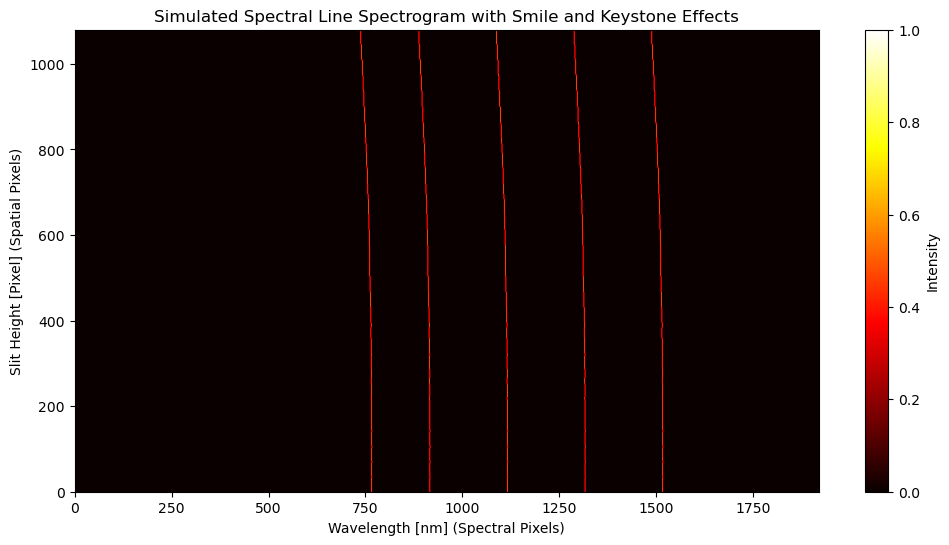

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the dimensions of the spectrogram
num_pixels_x = 1920  # Spectral pixels (horizontal axis)
num_pixels_y = 1080  # Spatial pixels (vertical axis)

# Step 2: Create an empty spectrogram (all black)
spectrogram = np.zeros((num_pixels_y, num_pixels_x))

# Step 3: Define spectral line positions (choose 4-5 lines)
spectral_line_positions = [750, 900, 1100, 1300, 1500]  # Adjust positions as needed

# Step 4: Add Smile Effect
smile_amplitude = 10  # Maximum vertical displacement (pixels)

# Uncomment ONE of the following blocks for either Half-Sinusoidal or Parabolic Smile Effect

# Half-Sinusoidal Smile Effect
for line_position in spectral_line_positions:
    for y in range(num_pixels_y):
        curve = int(smile_amplitude * np.sin(np.pi * y / num_pixels_y))  # Half-sinusoidal curve
        adjusted_position = max(0, min(num_pixels_x - 1, line_position + curve))
        spectrogram[y, adjusted_position] = 1.0

# # Parabolic Smile Effect
# for line_position in spectral_line_positions:
#     for y in range(num_pixels_y):
#         curve = int(smile_amplitude * ((y / num_pixels_y) - 0.5)**2)  # Parabolic curve
#         adjusted_position = max(0, min(num_pixels_x - 1, line_position + curve))
#         spectrogram[y, adjusted_position] = 1.0

# Step 5: Add Keystone Effect (horizontal shift of lines)
keystone_slope = 30  # Maximum horizontal shift at the top and bottom of the spectrogram
keystone_spectrogram = np.zeros_like(spectrogram)
for y in range(num_pixels_y):
    horizontal_shift = int(keystone_slope * (y / num_pixels_y - 0.5))  # Linear shift
    for x in range(num_pixels_x):
        shifted_position = max(0, min(num_pixels_x - 1, x + horizontal_shift))
        keystone_spectrogram[y, shifted_position] = spectrogram[y, x]

# Step 6: Add small Gaussian spread to simulate lamp effects (optional)
smile_keystone_spectrogram = np.zeros_like(keystone_spectrogram)
for line_position in spectral_line_positions:
    for y in range(num_pixels_y):
        curve = int(smile_amplitude * np.sin(np.pi * y / num_pixels_y))  # Use same smile effect curve
        horizontal_shift = int(keystone_slope * (y / num_pixels_y - 0.5))
        adjusted_position = max(0, min(num_pixels_x - 1, line_position + curve + horizontal_shift))
        smile_keystone_spectrogram[y, max(0, adjusted_position - 1):min(num_pixels_x, adjusted_position + 2)] += \
            np.exp(-((np.arange(max(0, adjusted_position - 1), min(num_pixels_x, adjusted_position + 2)) - adjusted_position)**2) / (2 * 0.5**2))

# Normalize the spectrogram
smile_keystone_spectrogram = smile_keystone_spectrogram / np.max(smile_keystone_spectrogram)

# Step 7: Visualize the distorted spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(smile_keystone_spectrogram, aspect='auto', cmap='hot', extent=[0, num_pixels_x, 0, num_pixels_y])
plt.colorbar(label="Intensity")
plt.title("Simulated Spectral Line Spectrogram with Smile and Keystone Effects")
plt.xlabel("Wavelength [nm] (Spectral Pixels)")
plt.ylabel("Slit Height [Pixel] (Spatial Pixels)")
plt.show()

# Step 8: Save the distorted spectrogram for further processing
np.savetxt("smile_keystone_spectral_lines.txt", smile_keystone_spectrogram, fmt="%.6f")


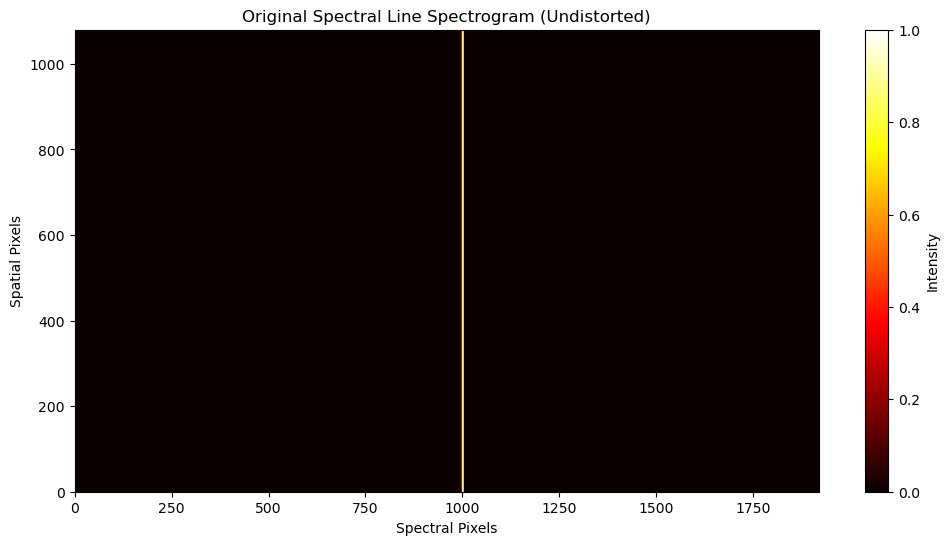

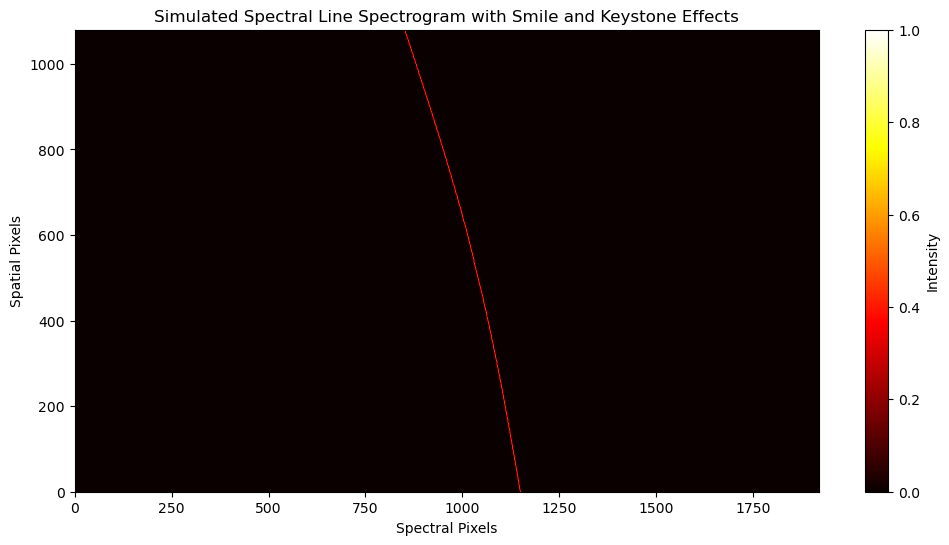

In [161]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the dimensions of the spectrogram
num_pixels_x = 1920  # Spectral pixels (horizontal axis)
num_pixels_y = 1080  # Spatial pixels (vertical axis)

# Step 2: Create an empty spectrogram (all black)
original_spectrogram = np.zeros((num_pixels_y, num_pixels_x))

# Step 3: Define spectral line positions (choose 4-5 lines)
spectral_line_positions = [1000]  # Adjust positions as needed

# Step 4: Add vertical spectral lines (original, undistorted image)
for line_position in spectral_line_positions:
    for y in range(num_pixels_y):
        original_spectrogram[y, max(0, line_position - 2):min(num_pixels_x, line_position + 3)] = 1.0

# Step 5: Add Smile Effect
smile_amplitude = 30  # Maximum vertical displacement (pixels)

# Uncomment ONE of the following blocks for either Half-Sinusoidal or Parabolic Smile Effect

# # Half-Sinusoidal Smile Effect
# spectrogram = np.zeros_like(original_spectrogram)  # Reset for distortion
# for line_position in spectral_line_positions:
#     for y in range(num_pixels_y):
#         curve = int(smile_amplitude * np.sin(np.pi * y / num_pixels_y))  # Half-sinusoidal curve
#         adjusted_position = max(0, min(num_pixels_x - 1, line_position + curve))
#         # Make the spectral line wider by spreading intensity across neighboring pixels
#         spectrogram[y, max(0, adjusted_position - 2):min(num_pixels_x, adjusted_position + 3)] = 1.0

# Parabolic Smile Effect
spectrogram = np.zeros_like(original_spectrogram)  # Reset for distortion
for line_position in spectral_line_positions:
    for y in range(num_pixels_y):
        curve = int(smile_amplitude * ((y / num_pixels_y) - 0.5)**2)  # Parabolic curve
        adjusted_position = max(0, min(num_pixels_x - 1, line_position + curve))
        # Make the spectral line wider by spreading intensity across neighboring pixels
        spectrogram[y, max(0, adjusted_position - 2):min(num_pixels_x, adjusted_position + 3)] = 1.0

# Step 6: Add Keystone Effect (horizontal shift of lines)
keystone_slope = 300  # Maximum horizontal shift at the top and bottom of the spectrogram
keystone_spectrogram = np.zeros_like(spectrogram)
for y in range(num_pixels_y):
    horizontal_shift = int(keystone_slope * (y / num_pixels_y - 0.5))  # Linear shift
    for x in range(num_pixels_x):
        shifted_position = max(0, min(num_pixels_x - 1, x + horizontal_shift))
        keystone_spectrogram[y, shifted_position] = spectrogram[y, x]

# Step 7: Add small Gaussian spread to simulate lamp effects (optional)
smile_keystone_spectrogram = np.zeros_like(keystone_spectrogram)
for line_position in spectral_line_positions:
    for y in range(num_pixels_y):
        curve = int(smile_amplitude * np.sin(np.pi * y / num_pixels_y))  # Use same smile effect curve
        horizontal_shift = int(keystone_slope * (y / num_pixels_y - 0.5))
        adjusted_position = max(0, min(num_pixels_x - 1, line_position + curve + horizontal_shift))
        smile_keystone_spectrogram[y, max(0, adjusted_position - 2):min(num_pixels_x, adjusted_position + 3)] += \
            np.exp(-((np.arange(max(0, adjusted_position - 2), min(num_pixels_x, adjusted_position + 3)) - adjusted_position)**2) / (2 * 0.5**2))

# Normalize the spectrogram
smile_keystone_spectrogram = smile_keystone_spectrogram / np.max(smile_keystone_spectrogram)

# Step 8: Visualize the original spectrogram (undistorted)
plt.figure(figsize=(12, 6))
plt.imshow(original_spectrogram, aspect='auto', cmap='hot', extent=[0, num_pixels_x, 0, num_pixels_y])
plt.colorbar(label="Intensity")
plt.title("Original Spectral Line Spectrogram (Undistorted)")
plt.xlabel("Spectral Pixels")
plt.ylabel("Spatial Pixels")
plt.show()

# Step 9: Visualize the distorted spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(smile_keystone_spectrogram, aspect='auto', cmap='hot', extent=[0, num_pixels_x, 0, num_pixels_y])
plt.colorbar(label="Intensity")
plt.title("Simulated Spectral Line Spectrogram with Smile and Keystone Effects")
plt.xlabel("Spectral Pixels")
plt.ylabel("Spatial Pixels")
plt.show()

# Step 10: Save the distorted spectrogram for further processing
#np.savetxt("smile_keystone_spectral_lines.txt", smile_keystone_spectrogram, fmt="%.6f")


In [177]:
print(smile_keystone_spectrogram.shape)
print(corrected_image[0,1030:1040])

(1080, 1920)
[[5 5 5]
 [5 5 5]
 [5 5 5]
 [5 5 5]
 [5 5 5]
 [5 5 5]
 [5 5 5]
 [5 5 5]
 [5 5 5]
 [5 5 5]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


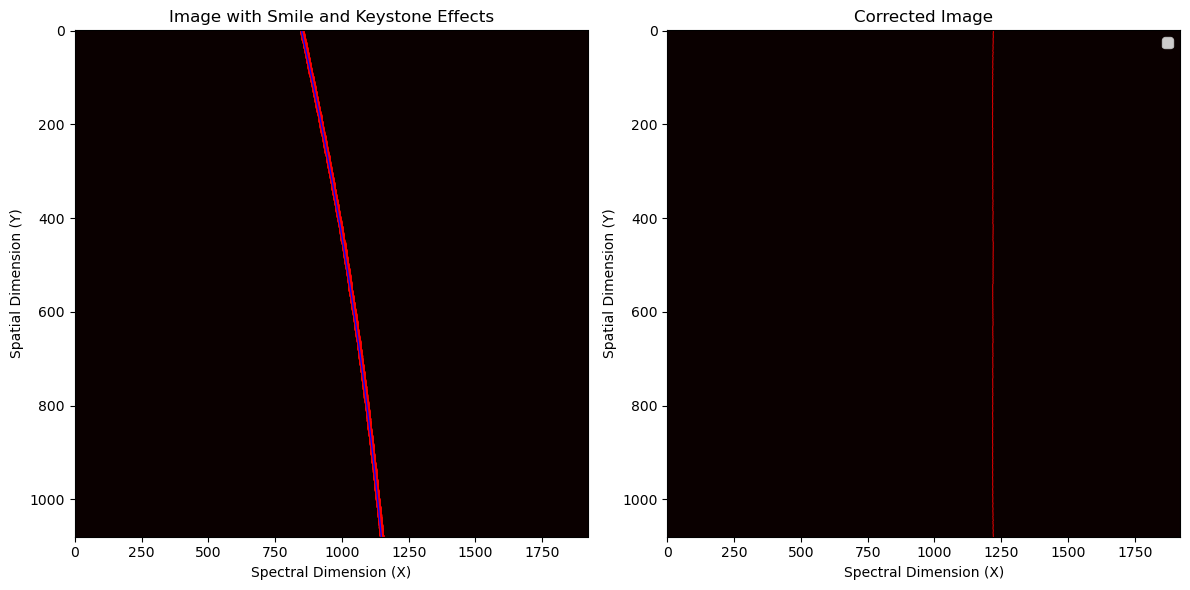

In [163]:
import matplotlib.pyplot as plt

# Load your image (hyperspectral frame)
image = smile_keystone_spectrogram  # Load as grayscale or use the correct channel

# Define the range of rows to process (e.g., the entire image or specific rows)
row_range = (0, image.shape[0])

# Locate emission lines
emission_points = np.array(locate_emission_lines(image, row_range, prominence=0.1))
x_detected, y_detected = emission_points[:, 0], emission_points[:, 1]

# Step 1: Fit circular arc to detected emission lines
center_x, center_y, radius = fit_circular_arc(emission_points)

# Generate fitted arc
y_arc = np.linspace(min(y_detected), max(y_detected), 1000)
x_arc = generate_arc(center_x, center_y, radius, y_arc)

# Step 2: Construct the shift matrix
emission_line_params = [(center_x, center_y, radius)]  # List of arc parameters for all detected lines
# shift_matrix = construct_shift_matrix(image, emission_line_params)
shift_matrix = construct_shift_matrix_paper(image, center_y, radius)

# Step 3: Apply the shift matrix to correct the image
corrected_image = apply_shift_matrix(image, shift_matrix)

# Step 4: Plot original and corrected images side by side
plt.figure(figsize=(12, 6))
# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='hot', aspect='auto')
# Overlay detected points
plt.plot(x_detected, y_detected, 'ro', markersize=2, label="Detected Emission Line")
# Overlay fitted arc
plt.plot(x_arc, y_arc, 'b-', linewidth=1, label="Fitted Circular Arc")
plt.title("Image with Smile and Keystone Effects")
plt.xlabel("Spectral Dimension (X)")
plt.ylabel("Spatial Dimension (Y)")

# Plot the corrected image
plt.subplot(1, 2, 2)
plt.imshow(corrected_image, cmap='hot', aspect='auto')
plt.title("Corrected Image")
plt.xlabel("Spectral Dimension (X)")
plt.ylabel("Spatial Dimension (Y)")
plt.tight_layout()
plt.legend()
plt.show()

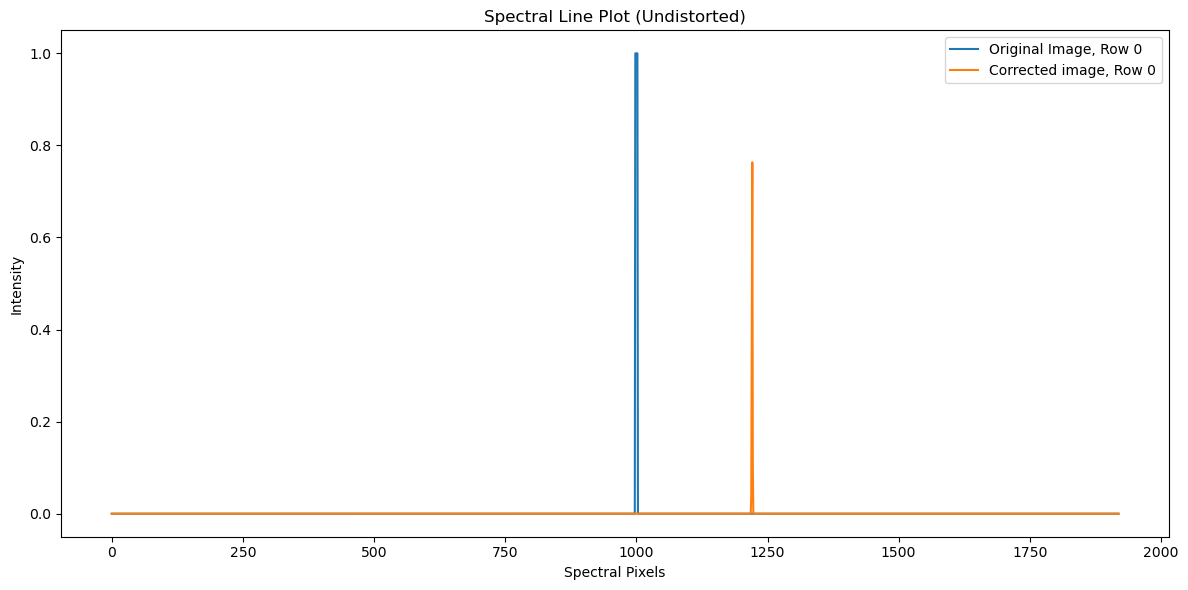

In [169]:
# Plot the original spectrogram as a line plot
plt.figure(figsize=(12, 6))
for y in range(0, num_pixels_y, num_pixels_y//1):  # Sample 10 rows evenly spaced
    plt.plot(original_spectrogram[y, :], label=f"Original Image, Row {y}")
    # plt.plot(smile_keystone_spectrogram[y, :], label=f"Distorted Image, Row {y}")
    plt.plot(corrected_image[y, :], label=f"Corrected image, Row {y}")
plt.title("Spectral Line Plot (Undistorted)")
plt.xlabel("Spectral Pixels")
plt.ylabel("Intensity")
plt.legend()

plt.tight_layout()
plt.show()

In [1]:
import cv2
import os
from datetime import datetime

# Directory to save images
save_directory = "./image"
os.makedirs(save_directory, exist_ok=True)

# Initialize the camera
camera = cv2.VideoCapture(0)  # Change index if you have multiple cameras

# Check if camera opened successfully
if not camera.isOpened():
    print("Error: Could not open camera.")
    exit()

# Initial settings
brightness = camera.get(cv2.CAP_PROP_BRIGHTNESS)
contrast = camera.get(cv2.CAP_PROP_CONTRAST)
zoom = camera.get(cv2.CAP_PROP_ZOOM)
focus = camera.get(cv2.CAP_PROP_FOCUS)

print("Press 'c' to capture an image, 'z' to exit.")
print("Use the following keys to adjust settings:")
print("  - Brightness: 'b' (increase) / 'n' (decrease)")
print("  - Contrast: '[' (increase) / ']' (decrease)")
print("  - Zoom: 'j' (increase) / 'k' (decrease)")
print("  - Focus: 'f' (increase) / 'g' (decrease)")
print("  - Gain: 'a' (increase) / 'd' (decrease)")
print("  - Exposure: 'e' (increase) / 'w' (decrease)")

try:
    while True:
        # Capture frame-by-frame
        ret, frame = camera.read()

        if not ret:
            print("Failed to capture image. Exiting...")
            break

        # Display the resulting frame
        cv2.imshow('Camera Feed', frame)

        # Wait for keypress
        key = cv2.waitKey(1) & 0xFF

        if key == ord('c'):
            # Capture and save the image with a timestamp
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            image_path = os.path.join(save_directory, f"captured_image_{timestamp}.png")
            cv2.imwrite(image_path, frame)
            print(f"Image saved to {image_path}")

        elif key == ord('z'):
            # Exit the loop
            print("Exiting...")
            break

        elif key == ord('b'):  # Increase brightness
            brightness = min(1.0, brightness + 0.1)
            camera.set(cv2.CAP_PROP_BRIGHTNESS, brightness)
            print(f"Brightness: {brightness:.2f}")

        elif key == ord('n'):  # Decrease brightness
            brightness = max(0.0, brightness - 0.1)
            camera.set(cv2.CAP_PROP_BRIGHTNESS, brightness)
            print(f"Brightness: {brightness:.2f}")

        elif key == ord('['):  # Increase contrast
            contrast = min(1.0, contrast + 0.1)
            camera.set(cv2.CAP_PROP_CONTRAST, contrast)
            print(f"Contrast: {contrast:.2f}")

        elif key == ord(']'):  # Decrease contrast
            contrast = max(0.0, contrast - 0.1)
            camera.set(cv2.CAP_PROP_CONTRAST, contrast)
            print(f"Contrast: {contrast:.2f}")

        elif key == ord('j'):  # Increase zoom
            zoom = min(1.0, zoom + 0.1)
            camera.set(cv2.CAP_PROP_ZOOM, zoom)
            print(f"Zoom: {zoom:.2f}")

        elif key == ord('k'):  # Decrease zoom
            zoom = max(0.0, zoom - 0.1)
            camera.set(cv2.CAP_PROP_ZOOM, zoom)
            print(f"Zoom: {zoom:.2f}")

        elif key == ord('f'):  # Increase focus
            focus = min(1.0, focus + 0.1)
            camera.set(cv2.CAP_PROP_FOCUS, focus)
            print(f"Focus: {focus:.2f}")

        elif key == ord('g'):  # Decrease focus
            focus = max(0.0, focus - 0.1)
            camera.set(cv2.CAP_PROP_FOCUS, focus)
            print(f"Focus: {focus:.2f}")

        elif key == ord('a'):  # Increase Gain
            gain = min(100.0, gain + 1.0)  # Adjust the range based on your camera
            camera.set(cv2.CAP_PROP_GAIN, gain)
            print(f"Gain: {gain:.2f}")

        elif key == ord('d'):  # Decrease Gain
            gain = max(0.0, gain - 1.0)
            camera.set(cv2.CAP_PROP_GAIN, gain)
            print(f"Gain: {gain:.2f}")

        elif key == ord('e'):  # Increase Exposure
            exposure = min(100.0, exposure + 1.0)  # Adjust the range based on your camera
            camera.set(cv2.CAP_PROP_EXPOSURE, exposure)
            print(f"Exposure: {exposure:.2f}")

        elif key == ord('w'):  # Decrease Exposure
            exposure = max(-10.0, exposure - 1.0)  # Negative values may set auto-exposure off
            camera.set(cv2.CAP_PROP_EXPOSURE, exposure)
            print(f"Exposure: {exposure:.2f}")

finally:
    # Release the camera and close all OpenCV windows
    camera.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)  # Ensures that all windows are properly closed


2025-01-03 10:50:36.816 python[36472:733242] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Press 'c' to capture an image, 'z' to exit.
Use the following keys to adjust settings:
  - Brightness: 'b' (increase) / 'n' (decrease)
  - Contrast: '[' (increase) / ']' (decrease)
  - Zoom: 'j' (increase) / 'k' (decrease)
  - Focus: 'f' (increase) / 'g' (decrease)
  - Gain: 'a' (increase) / 'd' (decrease)
  - Exposure: 'e' (increase) / 'w' (decrease)
Exiting...


In [5]:
import cv2

# Open the camera
camera = cv2.VideoCapture(0)

if not camera.isOpened():
    print("Error: Could not open camera.")
    exit()

# List of properties to check
properties = {
    "Brightness": cv2.CAP_PROP_BRIGHTNESS,
    "Contrast": cv2.CAP_PROP_CONTRAST,
    "Zoom": cv2.CAP_PROP_ZOOM,
    "Focus": cv2.CAP_PROP_FOCUS
}

print("Supported Camera Properties:")
for prop_name, prop_id in properties.items():
    value = camera.get(prop_id)
    if value != -1:
        print(f"{prop_name}: Supported (Current Value: {value})")
    else:
        print(f"{prop_name}: Not Supported")

camera.release()


Supported Camera Properties:
Brightness: Supported (Current Value: 0.0)
Contrast: Supported (Current Value: 0.0)
Zoom: Supported (Current Value: 0.0)
Focus: Supported (Current Value: 0.0)


In [7]:
import cv2

# Open the camera
camera = cv2.VideoCapture(0)

if not camera.isOpened():
    print("Error: Could not open camera.")
    exit()

# Properties to test
properties = {
    "Brightness": cv2.CAP_PROP_BRIGHTNESS,
    "Contrast": cv2.CAP_PROP_CONTRAST,
    "Zoom": cv2.CAP_PROP_ZOOM,
    "Focus": cv2.CAP_PROP_FOCUS
}

print("Adjusting Camera Properties:")

for prop_name, prop_id in properties.items():
    print(f"\nTesting {prop_name}...")
    for value in range(0, 101, 10):  # Incrementally test values from 0 to 100
        camera.set(prop_id, value / 100.0)  # Scale to a normalized range
        new_value = camera.get(prop_id)
        print(f"Set {prop_name} to {value / 100.0:.2f} -> Camera Value: {new_value:.2f}")

camera.release()


Adjusting Camera Properties:

Testing Brightness...
Set Brightness to 0.00 -> Camera Value: 0.00
Set Brightness to 0.10 -> Camera Value: 0.00
Set Brightness to 0.20 -> Camera Value: 0.00
Set Brightness to 0.30 -> Camera Value: 0.00
Set Brightness to 0.40 -> Camera Value: 0.00
Set Brightness to 0.50 -> Camera Value: 0.00
Set Brightness to 0.60 -> Camera Value: 0.00
Set Brightness to 0.70 -> Camera Value: 0.00
Set Brightness to 0.80 -> Camera Value: 0.00
Set Brightness to 0.90 -> Camera Value: 0.00
Set Brightness to 1.00 -> Camera Value: 0.00

Testing Contrast...
Set Contrast to 0.00 -> Camera Value: 0.00
Set Contrast to 0.10 -> Camera Value: 0.00
Set Contrast to 0.20 -> Camera Value: 0.00
Set Contrast to 0.30 -> Camera Value: 0.00
Set Contrast to 0.40 -> Camera Value: 0.00
Set Contrast to 0.50 -> Camera Value: 0.00
Set Contrast to 0.60 -> Camera Value: 0.00
Set Contrast to 0.70 -> Camera Value: 0.00
Set Contrast to 0.80 -> Camera Value: 0.00
Set Contrast to 0.90 -> Camera Value: 0.00
Se